# Scenarios evaluation

This part of the code contains the scripts to evaluate 12 different scenarios proposed for Iowa using different combinations of the parameters that 

In [1]:
%matplotlib inline 
import numpy as np 
import pylab as pl 
import pandas as pd 
from matplotlib import gridspec
from ifis_tools import series_tools as ser
from aclayer import core
import warnings
warnings.filterwarnings('ignore')

In [3]:
colors = {'ifc-hlm': '#d6604d',
         'a-hlm': '#92c5de',
         'd-hlm': '#225ea8'}

# KGE by events

## Code to obtain the kge of each product for all the events

In [4]:
Emet = pd.read_msgpack('data/results/Events_Metrics_sce.msg')

In [628]:
#Get the intersection of the kge indexes for all the events 
products = Emet['product'].unique().tolist()

kges = {}
bests = {}

for _i in [0.1, 0.75, 1.5]:
    #Do it for the initial product
    a,b = get_intersec_events(Emet, 'ifc-hlm',products[5],'kge',_i)
    c = b[['kge','link']]
    c.set_index([c.index, 'link'], inplace=True)
    c.rename(columns={'kge':products[5]}, inplace=True)
    #b.set_index([b.index, 'link'], inplace=True)
    #c['a-hlm'] = b['kge']

    #Iterate through products
    for prod in products[6:]:
        a,b = get_intersec_events(Emet, 'ifc-hlm',prod,'kge',_i)
        b.set_index([b.index, 'link'], inplace=True)
        idx = c.index.intersection(b.index)
        c = c.loc[idx]
        c[prod] = b.loc[idx, 'kge']

    #Obtain the best for each event
    best = c.idxmax(axis = 1)
    max_kge = c.max(axis=1)
    c['max_kge'] = max_kge
    bests.update({str(_i): best})
    for prod in ['a-hlm','d-hlm','t-hlm']:
        a,b = get_intersec_events(Emet, 'ifc-hlm',prod,'kge',_i)
        b.set_index([b.index, 'link'], inplace=True)
        idx = c.index.intersection(b.index)
        c = c.loc[idx]
        c[prod] = b.loc[idx, 'kge']

    a,b = get_intersec_events(Emet, 'ifc-hlm','a-hlm', 'kge',_i)
    a.set_index([a.index, 'link'], inplace=True)
    idx = c.index.intersection(a.index)
    c = c.loc[idx]
    c['ifc-hlm'] = a.loc[idx, 'kge']
    
    kges.update({str(_i): c})
    print(_i)

0.1
0.75
1.5


## KGE of the best scenario vs the HLM-l

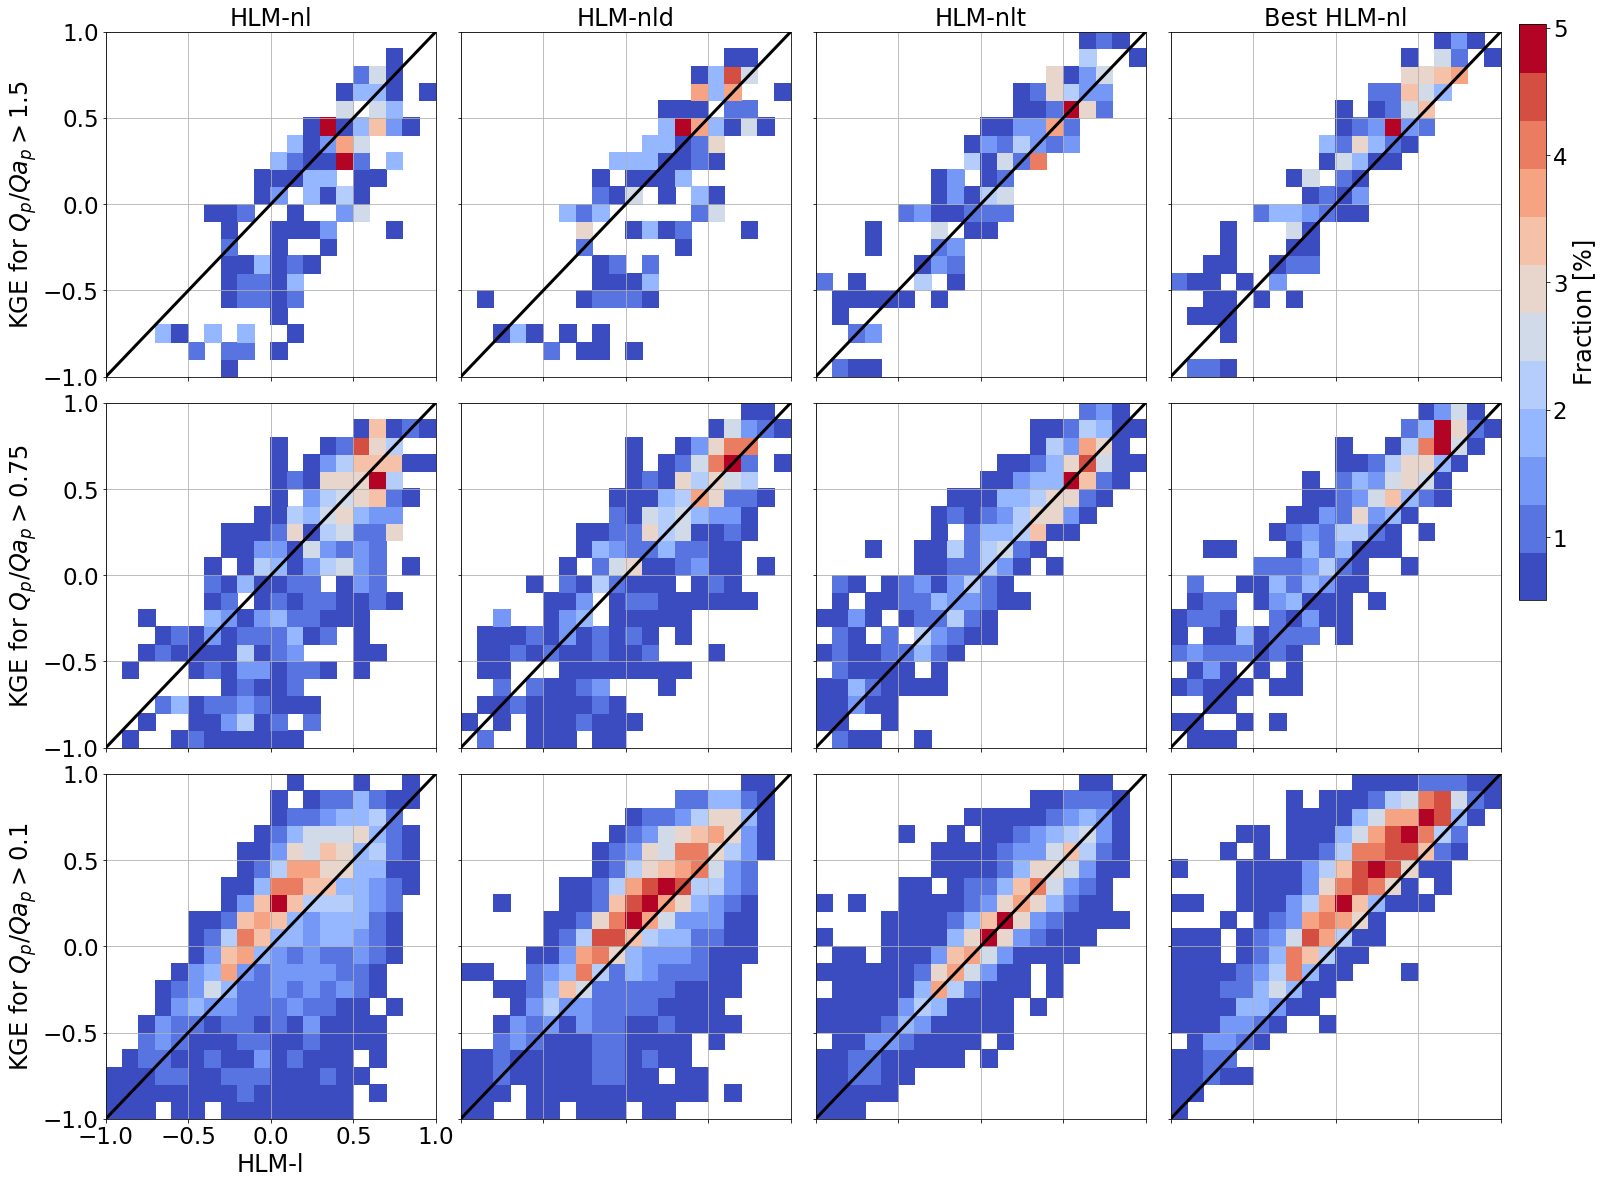

In [557]:
fig = pl.figure(figsize=(25,20))
cb_ax = fig.add_axes([.91,.485,.015,.4])
cmap = pl.get_cmap('coolwarm', 12) 

cont = 1
names = ['a) HLM-nl vs HLM-l','b) HLM-nld vs HLM-l','c) HLM-nlt vs HLM-l','e) HLM-b vs HLM-l']
ranges = [[1,5],[5,25],[20,300]]
for enu, _i in enumerate(['1.5','0.75','0.1']):
    c = kges[_i]
    for prod in ['a-hlm','d-hlm','t-hlm', 'max_kge']:
        ax = fig.add_subplot(3,4,cont)
        #a,b = get_intersec_events(Emet, 'ifc-hlm',prod,'kge',0.1)
        h = pl.hist2d(c['ifc-hlm'], c[prod], bins = np.arange(-1,1.2,0.1),density=True,
                      cmap = cmap,cmin = 0.05)
                      #vmin = ranges[enu][0], vmax = ranges[enu][-1], 
                      #cmin= ranges[enu][0], cmax=ranges[enu][-1], cmap = pl.get_cmap('coolwarm'))
        pl.plot([-1,1],[-1,1], 'k',lw = 3)
        ax.tick_params(labelsize = 23)
        ax.set_xticks([-1,-0.5,0.0,0.5,1.0])
        ax.set_yticks(ax.get_xticks())
        ax.grid()
        ax.set_xlim(-1,1)
        ax.set_ylim(-1,1)
        if cont  == 4:
            cbar = fig.colorbar(h[-1], orientation = 'vertical', cax = cb_ax)            
            cbar.ax.tick_params(labelsize = 23)
            cbar.ax.set_ylabel('Fraction [$\%$]', size = 24)
        if cont == 1:
            ax.set_ylabel('KGE for $Q_p/Qa_p > 1.5$', size = 24)
            ax.set_title('HLM-nl', size = 24)
        if cont == 5:
            ax.set_ylabel('KGE for $Q_p/Qa_p > 0.75$', size = 24)
        if cont == 9:
            ax.set_ylabel('KGE for $Q_p/Qa_p > 0.1$', size = 24)
            ax.set_xlabel('HLM-l', size = 24)
        if cont == 2:
            ax.set_title('HLM-nld', size = 24)
        if cont == 3:
            ax.set_title('HLM-nlt', size = 24)
        if cont == 4:
            ax.set_title('Best HLM-nl', size = 24)
        if cont != 9:
            ax.set_xticklabels([])
        if cont in [2,3,4,6,7,8,10,11,12]:
            ax.set_yticklabels([])
        
        cont +=1
pl.subplots_adjust(wspace=0.075, hspace=0.075)
pl.savefig('figures/kge_events_Best_vs_current_increasing_qp_ratio.png', bbox_inches = 'tight')

**Figure**: KGE of the HLM-nl versus the HLM-l. The First column correspond to the HLM-nl model with the 2% slope setup. The second column to the HLM-nld or distributed setup. The third column to the 2% tiled setup (HLM-nlt). The last column corresponds to the best setup found for each case. Additionally, each row corresponds to cases above a certain $Q_p/Qa_p$ ratio.

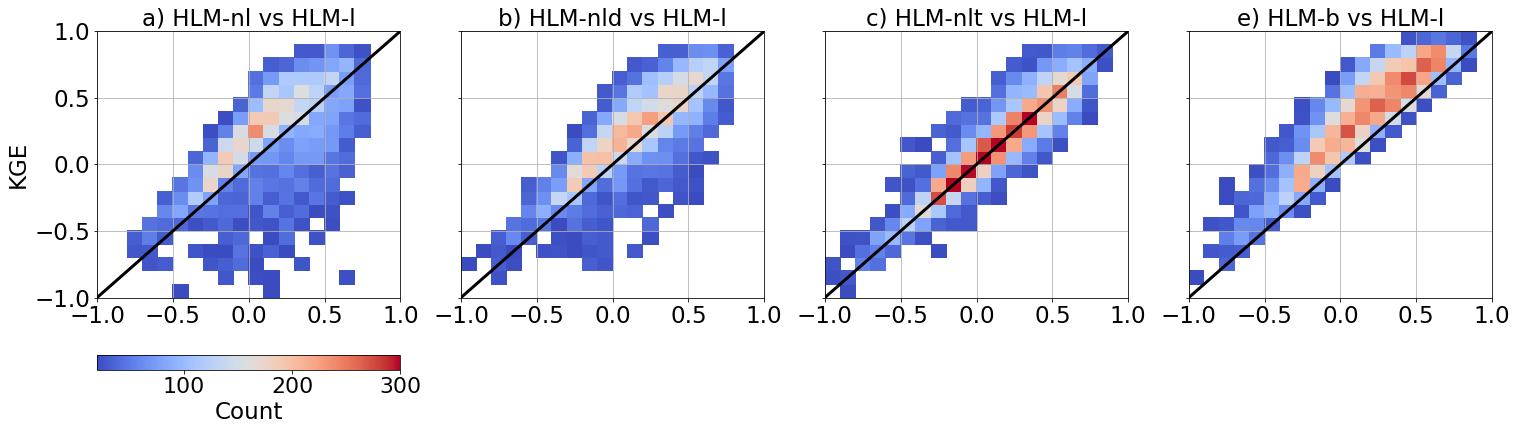

In [251]:
fig = pl.figure(figsize=(25,7))
cont = 1
names = ['a) HLM-nl vs HLM-l','b) HLM-nld vs HLM-l','c) HLM-nlt vs HLM-l','e) HLM-b vs HLM-l']
for prod in ['a-hlm','d-hlm','t-hlm', 'max_kge']:
    ax = fig.add_subplot(1,4,cont)
    #a,b = get_intersec_events(Emet, 'ifc-hlm',prod,'kge',0.1)
    h = pl.hist2d(c['ifc-hlm'], c[prod], bins = np.arange(-1,1.2,0.1),
                  vmin = 20, vmax = 300, 
                  cmin=20, cmax=1000, cmap = pl.get_cmap('coolwarm'))
    cmap = pl.colorbar(orientation = 'horizontal', pad = 0.15)
    pl.plot([-1,1],[-1,1], 'k',lw = 3)
    ax.tick_params(labelsize = 23)
    ax.set_xticks([-1,-0.5,0.0,0.5,1.0])
    ax.set_yticks(ax.get_xticks())
    ax.grid()
    if cont != 1:
        cmap.remove()
        ax.set_yticklabels([])
    else:
        cmap.ax.tick_params(labelsize = 22)
        cmap.ax.set_xlabel('Count', size = 23)
        ax.set_ylabel('KGE', size = 23)
    ax.set_xlim(-1,1)
    ax.set_ylim(-1,1)
    ax.set_title(names[cont-1], size = 23)
    cont+=1
pl.savefig('figures/kge_events_Best_vs_current.png', bbox_inches = 'tight')

**Figure**: Same as the previous figure, here is for all the cases with $Q_p/Q1_p > 0.1$.

### Histogram of the Best scenaio vs HLM-l

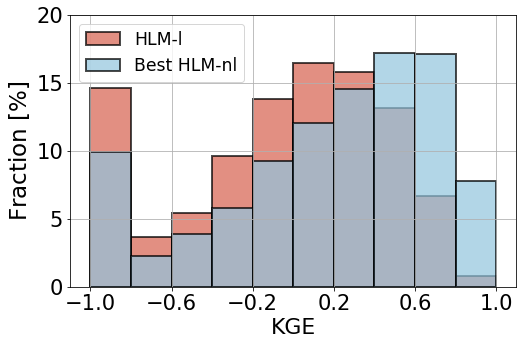

In [558]:
fig = pl.figure(figsize=(8,5))
ax = fig.add_subplot(111)
bins = np.arange(-1,1.2,0.2)
h,b = core.get_histogram(c['ifc-hlm'], bins, inf = -1)
h = 100*h/h.sum()
pl.bar(b[:-1], h, 0.2,align = 'edge', color = colors['ifc-hlm'], alpha = 0.7, edgecolor = 'k', lw = 2,
      label = 'HLM-l')
h,b = core.get_histogram(c['max_kge'], bins, inf = -1)
h = 100*h/h.sum()
pl.bar(b[:-1], h, 0.2,align = 'edge', color = colors['a-hlm'], alpha = 0.7, edgecolor = 'k', lw = 2,
      label = 'Best HLM-nl')
ax.tick_params(labelsize = 21)
ax.set_xlabel('KGE', size = 22)
ax.set_xticks([-1,-0.6,-0.2,0.2,0.6,1.0])
ax.set_yticks([0,5,10,15,20])
ax.legend(loc = 0, fontsize = 'xx-large')
ax.set_ylabel('Fraction [$\%$]', size = 23)
ax.grid()
pl.savefig('figures/kge_histogram_best_vs_HLM-l.png', bbox_inches = 'tight')

### Best scenario frequency

In [677]:
def get_pos_conf(link):
    d = best.xs(link,level = 'link')
    pos = d.value_counts().index[0]
    conf = d.value_counts().values[0] / d.value_counts().sum()
    return pos,conf

In [692]:
level = '0.1'
best = bests[level].copy()
c = kges[level].copy()

numbers = [21,22,23,24,31,32,33,34,41,42,43,44]
numbers = np.arange(1,13)
for i,j in zip(products[5:], numbers):
    best.loc[best == i] = j

best_sce = {}
links = np.unique(best.index.get_level_values(level='link')).tolist()
for l in links:
    pos, conf = get_pos_conf(l)
    b_kge = np.percentile(c.xs(l, level = 'link')['max_kge'], 50)
    i_kge = np.percentile(c.xs(l, level = 'link')['ifc-hlm'], 50)
    best_sce.update({l:{'product': pos, 'p':conf,'best_kge':b_kge, 'ifc-hlm':i_kge}})
    
best_sce = pd.DataFrame(best_sce).T

Text(11.5, 26, '$k_{if} = 0.04$')

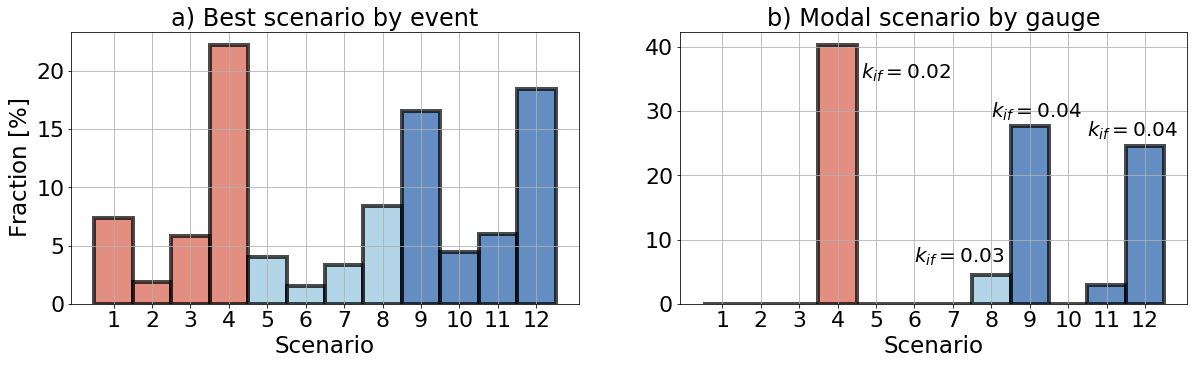

In [707]:
fig = pl.figure(figsize=(20,5))

ax = fig.add_subplot(121)
h,b = core.get_histogram(best, np.arange(1,14))
bar = pl.bar(b[1:],h*100,1, alpha = 0.7)
ax.tick_params(labelsize = 22)
ax.set_xlabel('Scenario', size = 23)
ax.set_ylabel('Fraction [$\%$]', size = 23)
ax.set_xticks(np.arange(2,14))
ax.set_xticklabels(np.arange(1,13))
ax.grid()
ax.set_title('a) Best scenario by event', size = 24)
for i in [0,1,2,3]:
    bar[i].set_color(colors['ifc-hlm'])
    bar[i].set_edgecolor('k')
    bar[i].set_linewidth(4.0)
for i in [4,5,6,7]:
    bar[i].set_color(colors['a-hlm'])
    bar[i].set_edgecolor('k')
    bar[i].set_linewidth(4.0)
for i in [8,9,10,11]:
    bar[i].set_color(colors['d-hlm'])
    bar[i].set_edgecolor('k')
    bar[i].set_linewidth(4.0)

ax = fig.add_subplot(122)
h,b = core.get_histogram(best_sce['product'], np.arange(1,14))
bar = pl.bar(b[1:],h*100,1, alpha = 0.7)
ax.tick_params(labelsize = 22)
ax.set_xlabel('Scenario', size = 23)
ax.set_xticks(np.arange(2,14))
ax.set_xticklabels(np.arange(1,13))
ax.grid()
ax.set_title('b) Modal scenario by gauge', size = 24)
for i in [0,1,2,3]:
    bar[i].set_color(colors['ifc-hlm'])
    bar[i].set_edgecolor('k')
    bar[i].set_linewidth(4.0)
for i in [4,5,6,7]:
    bar[i].set_color(colors['a-hlm'])
    bar[i].set_edgecolor('k')
    bar[i].set_linewidth(4.0)
for i in [8,9,10,11]:
    bar[i].set_color(colors['d-hlm'])
    bar[i].set_edgecolor('k')
    bar[i].set_linewidth(4.0)
ax.text(5.6,35,'$k_{if} = 0.02$',size = 20)
ax.text(7,6.5,'$k_{if} = 0.03$',size = 20)
ax.text(9,29,'$k_{if} = 0.04$',size = 20)
ax.text(11.5,26,'$k_{if} = 0.04$',size = 20)


In [553]:
best_sce.index.rename('link', inplace=True)
best_sce.to_csv('data/processed/best_kge_by_event_4sc.csv')

### Best Scenario vs Confidence

In [353]:
bkge = np.array([float(i) for i in best_sce['best_kge'].values])
p = np.array([float(i) for i in best_sce['p'].values])
prod = best_sce['product'].values.tolist()
prod_numeric = np.array([int(i[6:]) for i in prod])

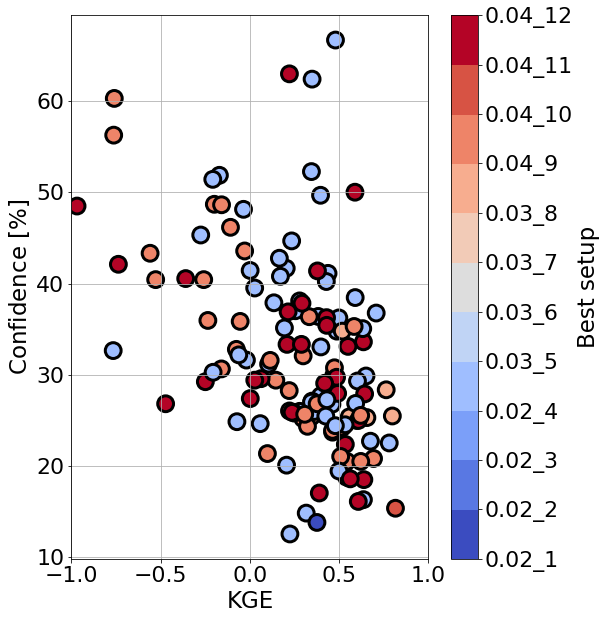

In [502]:
cmap = pl.get_cmap('coolwarm', 11) 
fig = pl.figure(figsize=(8,10))
ax = fig.add_subplot(111)
pl.scatter(bkge, p, c = prod_numeric, cmap=cmap, s = 250, edgecolor = 'k', lw = 3)
cbar = pl.colorbar()
cbar.ax.tick_params(labelsize = 22)
cbar.set_label('Best setup', size = 23)
cbar.set_ticks(range(1,13))
cbar.set_ticklabels([i[1:] for i in products[5:]])
pl.xlim(-1,1)
ax.tick_params(labelsize = 22)
ax.set_xlabel('KGE', size = 23)
ax.set_ylabel('Confidence [$\%$]', size = 23)
ax.grid()
pl.savefig('figures/kge_vs_confidence.png', bbox_inches = 'tight')

# Qpeak difference

In [ ]:
bins = []
val = 50
bins.append(val)
for i in range(5):
    val *= 2.5
    bins.append(val)
bins = np.array(bins)
bins2 = (bins[:-1]+bins[1:])/2.

fig = pl.figure(figsize=(20,8))
cont = 1
pre = ''
name = ['a)','b)','c)','d)','e)','f)','g)','h)','i)']
for y1,y2 in zip([2002,2009,2015],[2008,2014,2018]):
    y1t = str(y1)
    y2t = str(y2)
    
    for model,co in zip(['d-hlm'],range(2)):
        ax = fig.add_subplot(1,3,cont)

        a,b,idx = core.get_intersec('qpeak', 'usgs','ifc-hlm',Emet, y1t,y2t)
        po,ps = core.percentiles(a['qpeak'].loc[idx], b['qpeak'].loc[idx], bins = bins)
        po2,ps2 = core.percentiles(a['qpeak'].loc[idx], a['qpeak'].loc[idx], bins = bins)
        c1 = a['qpeak'].loc[idx].values
        c2 = b['qpeak'].loc[idx].values
        p = np.where((c1>100) & (c2 > 100))[0]
        ax.scatter(c1[p],c2[p], c = '#d6604d',s = 100, edgecolors='k', alpha = 0.7, label = pre+'Operational')
        ax.plot(ps2,ps, '#b2182b',lw = 5)

        a,b,idx = core.get_intersec('qpeak', 'usgs',model,Me,y1t,y2t)
        po,ps = core.percentiles(a['qpeak'].loc[idx], b['qpeak'].loc[idx], bins = bins)
        c1 = a['qpeak'].loc[idx].values
        c2 = b['qpeak'].loc[idx].values
        p = np.where((c1>100) & (c2 > 100))[0]
        ax.scatter(c1[p],c2[p], c = '#92c5de',s = 100, edgecolors='k', alpha = 0.7, label = pre+'Active')
        ax.plot(ps2,ps, '#053061',lw = 5)

        pl.loglog([5,6000],[5,6000], 'k', lw = 3)
        ax.set_title(name[cont-1]+' '+y1t+'-'+y2t, size = 22)
        ax.set_xlim(100,6000)
        ax.set_ylim(100,6000)
        ax.vlines(bins2, 100,6000, lw = 0.5, ls = '--')
        ax.hlines(bins2, 100,6000, lw = 0.5, ls = '--')
        ax.tick_params(labelsize = 20)
        if cont == 1:
            ax.legend(loc = 0, fontsize = 'xx-large')

        if cont == 1:  
            ax.set_ylabel('Simulated peak flow [$m^3 \cdot s^{-1}$]', size = 22)
            ax.set_xlabel('Observed peak flow [$m^3 \cdot s^{-1}$]', size = 22)
        if cont == 2:
            pre = '_'
        cont+=1
pl.savefig('figures/Peak_active_vs_operational.png', bbox_inches = 'tight')

In [474]:
Emet.head()

,product,qpeak,qmean,qmax_anual,qpeakDiff,tpeakDiff,kge,nse,pbias,up_area,link
2012-06-01 07:00:00,usgs,94.1640,34.23412,119.55288,0.0,0.0,1.0,1.0,0.0,4323.5576,555741
2012-06-05 20:00:00,usgs,94.6596,34.23412,119.55288,0.0,0.0,1.0,1.0,0.0,4323.5576,555741
2013-06-24 21:00:00,usgs,99.4740,34.23412,119.55288,0.0,0.0,1.0,1.0,0.0,4323.5576,555741
2014-06-21 01:00:00,usgs,204.3288,34.23412,119.55288,0.0,0.0,1.0,1.0,0.0,4323.5576,555741
2014-06-27 00:00:00,usgs,176.4336,34.23412,119.55288,0.0,0.0,1.0,1.0,0.0,4323.5576,555741


In [504]:
def get_qmax_intersec(product, y1,y2):
    u = Emet.loc[Emet['product'] == 'usgs',['qpeak','qmax_anual','link']][y1:y2]
    u.set_index([u.index, 'link'], inplace=True)
    a = Emet.loc[Emet['product'] == product,['qpeak','qmax_anual','link']][y1:y2]
    a.set_index([a.index, 'link'], inplace=True)
    idx = a.index.intersection(u.index)
    return u.loc[idx,'qpeak'] / u.loc[idx,'qmax_anual'], a.loc[idx,'qpeak'] / u.loc[idx,'qmax_anual']

In [479]:
def get_qmax_intersec(product, y1,y2):
    u = Emet.loc[Emet['product'] == 'usgs',['qpeak','qmean','link']][y1:y2]
    u.set_index([u.index, 'link'], inplace=True)
    a = Emet.loc[Emet['product'] == product,['qpeak','qmean','link']][y1:y2]
    a.set_index([a.index, 'link'], inplace=True)
    idx = a.index.intersection(u.index)
    return u.loc[idx,'qpeak'] / u.loc[idx,'qmean'], a.loc[idx,'qpeak'] / u.loc[idx,'qmean']

In [ ]:
get_qmax_intersec('d-hlm', '2002','2008')

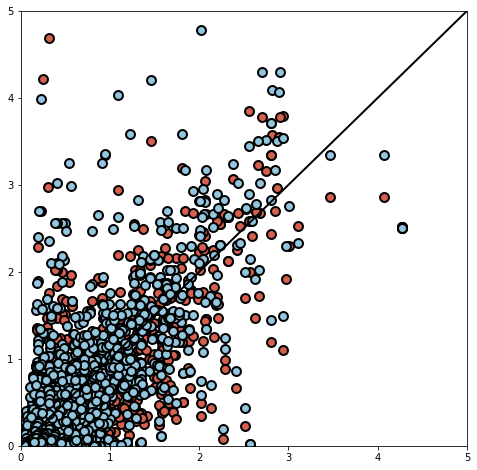

In [506]:
fig = pl.figure(figsize=(8,8))

years = [[2002,2008],[2009,2014],[2015,2018]]
for i,y in enumerate(years[:1]):
    #ax = fig.add_subplot(1,3,i+1)
    ax = fig.add_subplot(1,1,1)
    x,y1 = get_qmax_intersec('ifc-hlm', str(y[0]),str(y[1]))
    pl.scatter(x, y1, c = colors['ifc-hlm'], s = 80, edgecolor = 'k', lw = 2, label = 'HLM-l')
    x,y1 = get_qmax_intersec('d-hlm', str(y[0]),str(y[1]))
    pl.scatter(x, y1, c = colors['a-hlm'], s = 80, edgecolor = 'k', lw = 2, label = 'HLM-nld')
    pl.plot([0,5],[0,5], 'k', lw = 2)
    ax.set_xlim(0,5)
    ax.set_ylim(0,5)


(array([ 127.,  316.,  210.,  288.,  439.,  642.,  995., 1887., 3901.,
        6829., 2179.,  969.,  643.,  510.,  362.,  230.,  210.,  189.,
         133.]),
 array([-1.        , -0.89473684, -0.78947368, -0.68421053, -0.57894737,
        -0.47368421, -0.36842105, -0.26315789, -0.15789474, -0.05263158,
         0.05263158,  0.15789474,  0.26315789,  0.36842105,  0.47368421,
         0.57894737,  0.68421053,  0.78947368,  0.89473684,  1.        ]),
 <a list of 19 Patch objects>)

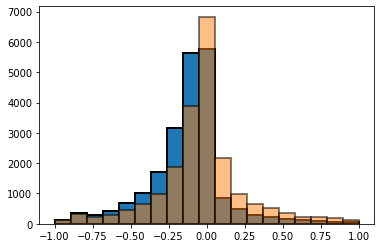

In [533]:
x,y1 = get_qmax_intersec('ifc-hlm', '2002','2018')
er = y1 - x
pl.hist(er[np.isfinite(er)], bins = np.linspace(-1,1,20), edgecolor = 'k', lw = 2)

x,y1 = get_qmax_intersec('s0.02_4',  '2002','2018')
er = y1 - x
pl.hist(er[np.isfinite(er)], bins = np.linspace(-1,1,20), edgecolor = 'k', lw = 2, ALPHA = 0.5)

In [483]:
def get_qmax_intersec(product, y1,y2):
    u = Emet.loc[Emet['product'] == 'usgs',['qpeak','qmax_anual','link']][y1:y2]
    u.set_index([u.index, 'link'], inplace=True)
    a = Emet.loc[Emet['product'] == product,['qpeak','qmax_anual','link']][y1:y2]
    a.set_index([a.index, 'link'], inplace=True)
    idx = a.index.intersection(u.index)
    x = u.loc[idx,'qpeak'] / u.loc[idx,'qmax_anual']
    y = a.loc[idx,'qpeak'] / u.loc[idx,'qmax_anual']
    return (x-y)/x 

<BarContainer object of 9 artists>

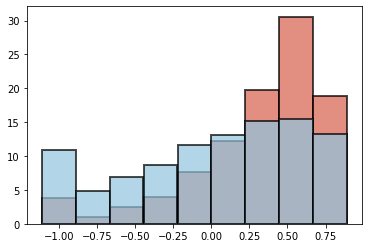

In [503]:
x = get_qmax_intersec('ifc-hlm', '2002','2008')
h,b = core.get_histogram(x, np.linspace(-1,1,10), inf = -1, sup = 1)
h = 100 * h/h.sum()
pl.bar(b[:-1], h, 0.22, color = colors['ifc-hlm'], alpha = 0.7, edgecolor = 'k', lw = 2)
x = get_qmax_intersec('s0.02_4', '2002','2008')
h,b = core.get_histogram(x, np.linspace(-1,1,10), inf = -1, sup = 1)
h = 100 * h/h.sum()
pl.bar(b[:-1], h, 0.22, color = colors['a-hlm'], alpha = 0.7, edgecolor = 'k', lw = 2)